# **Technologies for Anti-Money Laundering and Financial Crime**
# Lab Exercise 5 - February 2023
### *COMP-1831-M01-2022-23*

This lab series is centered around fraud detection using Machine Learning technologies. More precisely you are presented with the following problem statement:

>You are given a dateset of financial transactions, some of which are fraudulent. The objective of this exercises is to classify the fraudulent transaction as accurately as possible using a Decision Tree classifier.


## Dataset

First things first, let's download the dataset that we will be working with, for the duration of this lab. 

The file can be downloaded using the `gdown` command which is a special command embedded in Colab's runtime that downloads files from Google drive. 

In [1]:
!gdown --id 1A_EE7CIltvI5YfP_EPzmQ5jeNezT7cfF

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1A_EE7CIltvI5YfP_EPzmQ5jeNezT7cfF
To: /content/transactions.csv
100% 16.1M/16.1M [00:00<00:00, 83.1MB/s]


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [12]:
# Read data

df = pd.read_csv("/content/transactions.csv", index_col=0)#.set_index("idItem")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


## Are there any null values in the dataset?

It is always good practice to check whether there are null values in your dataset because they can cause issues with classification/transformation algorithms. Alternatively, sometimes a null value is a rich piece of information so it may be beneficial to encode it using a concrete number (i.e. 0). It always depends on the problem statement and how the data was acquired.

In [7]:
nulls = df.isnull().sum(axis=0).sort_values(ascending=False); nulls

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

## Dataset Columns

**date**: Date and time of transaction

**client**: Sender account’s number

**usercategory**: User’s grouping according to their possible spending behaviour

**profile**: Account type (1-personal or 2-business)

**location**: Sender’s location

**typeTrans**: Type’s of transaction operations 

**amount**: Transaction amount

**balance**: Sender’s account balance after each transaction

**clientB**: Reciever’s account number

**profileB**: Account type 

**locationB**: Receiver’s location

**balanceB**: Receiver’s account balance after each transaction

**Class**: Class of misuse scenarios

**suspicious**: Transaction label (fraud or non-fraud)



In [9]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [8]:
df.dropna().describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,200000.00000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000
mean,10.06589,1.808112e+05,8.821957e+05,9.001938e+05,9.411592e+05,1.191866e+06,0.000735
std,2.12174,3.291800e+05,2.766264e+06,2.803759e+06,2.373010e+06,2.655236e+06,0.027101
min,1.00000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,9.00000,1.201612e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,10.00000,6.872104e+04,1.951000e+04,0.000000e+00,5.055850e+04,1.320839e+05,0.000000
75%,12.00000,2.290791e+05,1.915686e+05,2.275212e+05,7.645361e+05,1.189164e+06,0.000000
max,13.00000,1.000000e+07,3.893942e+07,3.894623e+07,3.903958e+07,3.904248e+07,1.000000


# Class imbalance
In data-driven fraud detection systems, one of the most common challenges is to tackle class imbalance. In the real world, fraudulent transactions copmprise of a tiny proportial in comparison with legitimate transactions. As a result, AI models face risks of overfitting on the legitimate data. 

## Samping techniques

There are many ways to address class imblalance by using sampling techniques. We list three of the most common techniques below. Note that this not an exhaustive list nor always the most effective techniques, there are many more.

1. **Random Under-sampling:**: Remove recods from the majority class (non-fraud)such that its size approximates the minority class's size.

![Under sampling](https://miro.medium.com/max/611/1*ACQmCz79mMlw0NapBbkBGA.png)

2. **Random Over-sampling:** Clone records from the minority class (fraud) such that its approximates the majority's class's size.

![Over sampling](https://miro.medium.com/max/700/1*0Pg--Ml5inAkc76AeJn3RA.png)

3. **SMOTE (Synthetic Minority Over-sampling technique):** SMOTE is a more elaborate over-sampling technique as it creates new synthetic data by clustering the data using KNN (K-nearest neighbour) algorithm and samping new data on the lines that join the minority class points.

![SMOTE](https://miro.medium.com/max/641/1*EAVoNiKnLfhA52GgoMS6Xg.png)


0    199853
1       147
Name: isFraud, dtype: int64

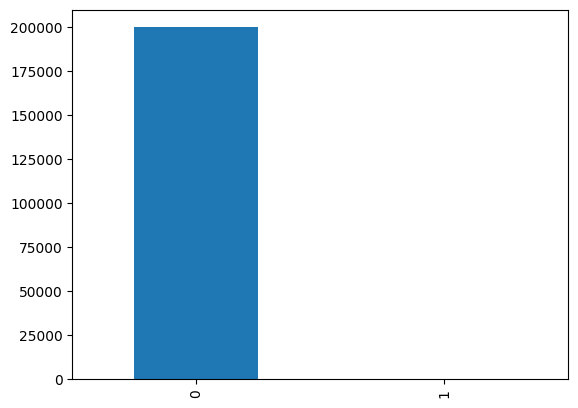

In [13]:
df['isFraud'].value_counts().plot(kind='bar')
df['isFraud'].value_counts()

In [15]:
print('Proportion of suspicious trades: {:.2f}%'.format(df['isFraud'].value_counts()[1]/df['isFraud'].size * 100))

Proportion of suspicious trades: 0.07%


### Under Sampling

Balance classes using user sampling

<Axes: >

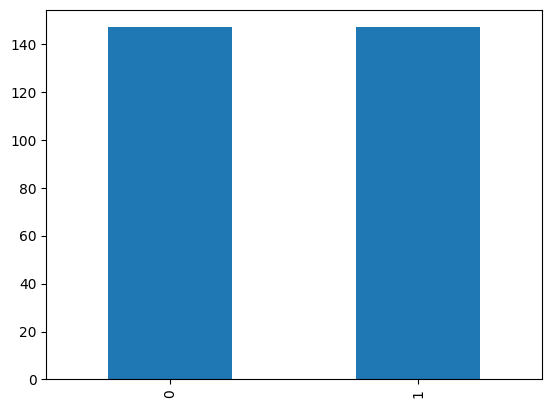

In [16]:
suspicious_count = len(df[df['isFraud'] == 1])
non_suspicious_count = len(df[df['isFraud'] == 0])

sampled_non_suspicious = df[df['isFraud'] == 0].sample(n=suspicious_count)
suspicious = df[df['isFraud'] == 1]

sampled_non_suspicious.reset_index(drop=True, inplace=True)
suspicious.reset_index(drop=True, inplace=True)

balanced_df = pd.concat([sampled_non_suspicious, suspicious]).reset_index(drop=True);

balanced_df['isFraud'].value_counts().plot(kind='bar')

# Feature Correlation

By creating correlation maps we can identify features that are closely correlated with the legitimacy of our transactions. This can be a crucial step when performing dimensionality reduction, remoing/adding features.

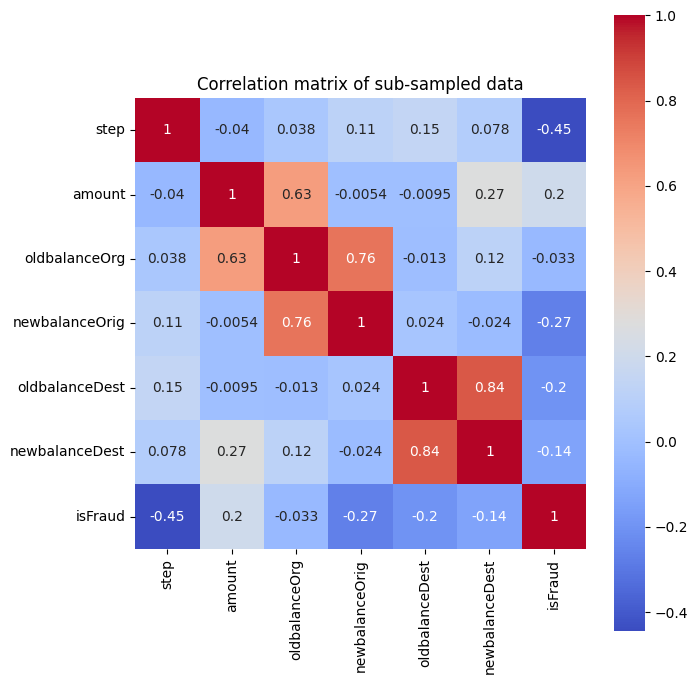

In [22]:
corrmat = balanced_df.corr()
f, ax = plt.subplots(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Correlation matrix of sub-sampled data')
sns.heatmap(corrmat, vmax=1, square=True, annot=True, cmap='coolwarm')
plt.show()

## Pair plotting

Sometimes you just don't really have any clues about data correlations thus plotting all the attributes together in pairs can reveal hidden relationships or odd patterns. Note that the more the attributes the more time it will take to plot everything together. 

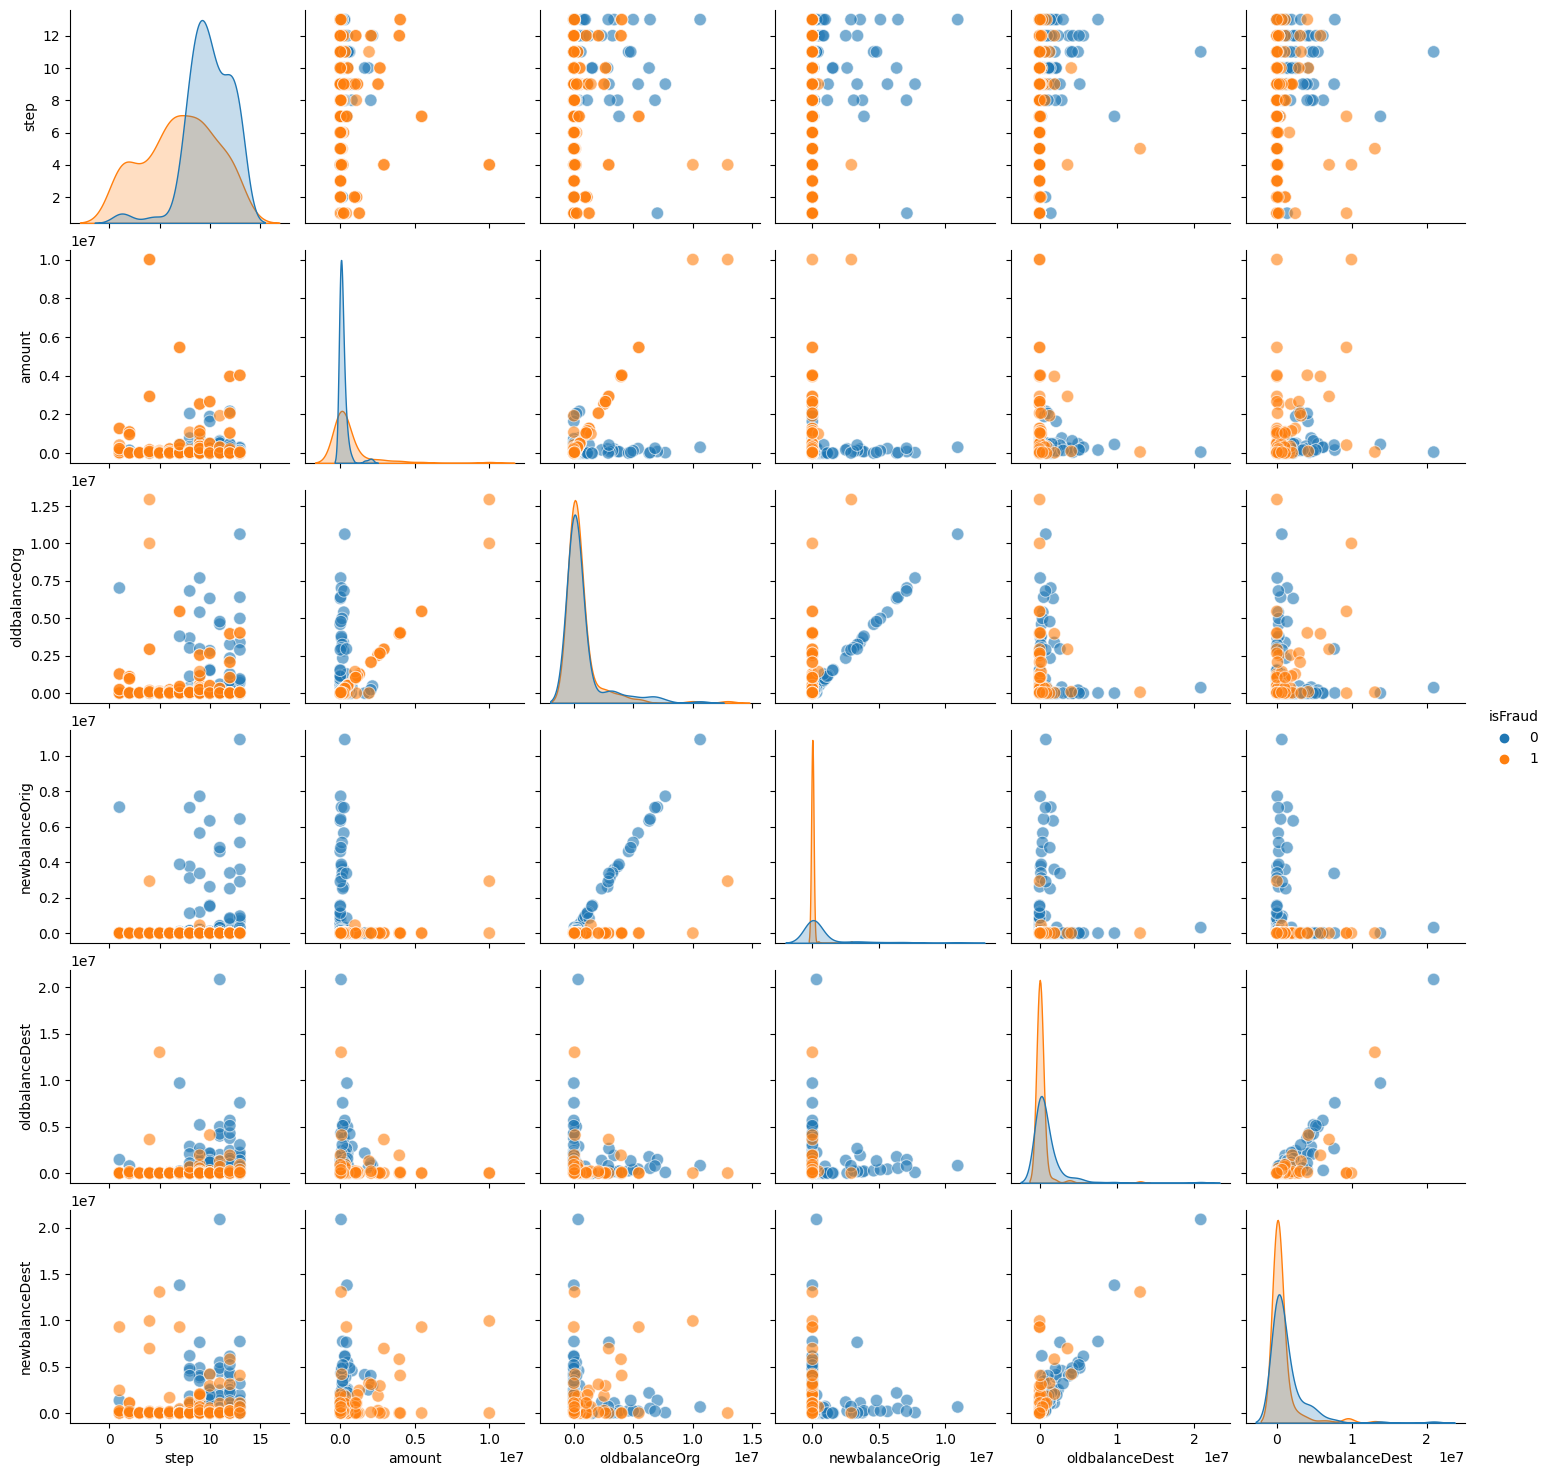

In [23]:
sns.pairplot(balanced_df, hue="isFraud", plot_kws = {'alpha': 0.6, 's': 80})

Confirm that transactions with ProfileB as 1 are never fraudulent.

In [ ]:
balanced_df[['profileB','suspicious']].value_counts()

In [25]:
balanced_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [37]:
balanced_df.type.value_counts()

CASH_OUT    125
TRANSFER     87
PAYMENT      59
CASH_IN      22
DEBIT         1
Name: type, dtype: int64

<Axes: xlabel='isFraud', ylabel='newbalanceOrig'>

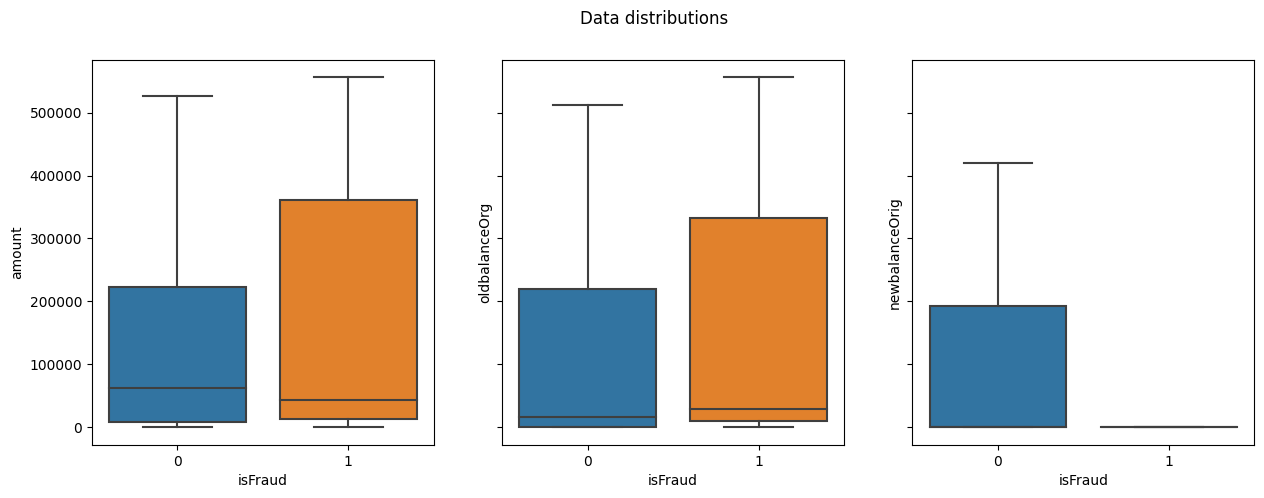

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Data distributions')

sns.boxplot(ax=axes[0], x="isFraud", y="amount", data=balanced_df,showfliers=False)
sns.boxplot(ax=axes[1], x="isFraud", y="oldbalanceOrg", data=balanced_df,showfliers=False)
sns.boxplot(ax=axes[2], x="isFraud", y="newbalanceOrig", data=balanced_df,showfliers=False)

## Bonus visualization package
Another handy visualisation package is `sweetviz`. With sweetviz you can compare or perform EDA on dataframes with just few lines of codes. On top of that it provides an interactive interface to display further statistical analysis on each feature of the dataset.

In [28]:
!pip install sweetviz==2.1.4

                                             |          | [  0%]   00:00 -> (? left)


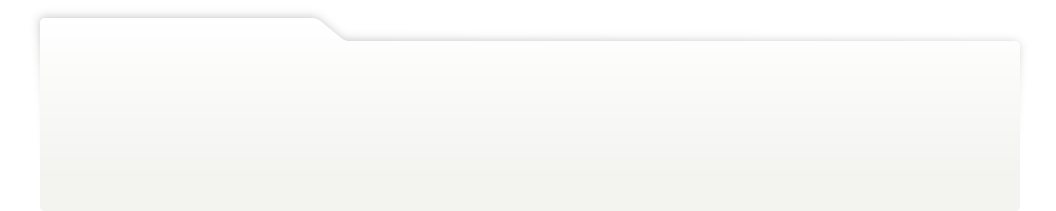
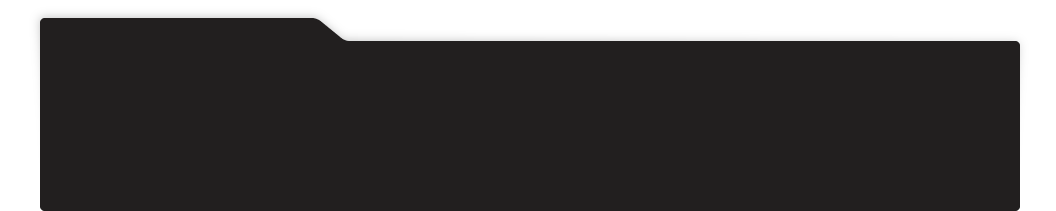
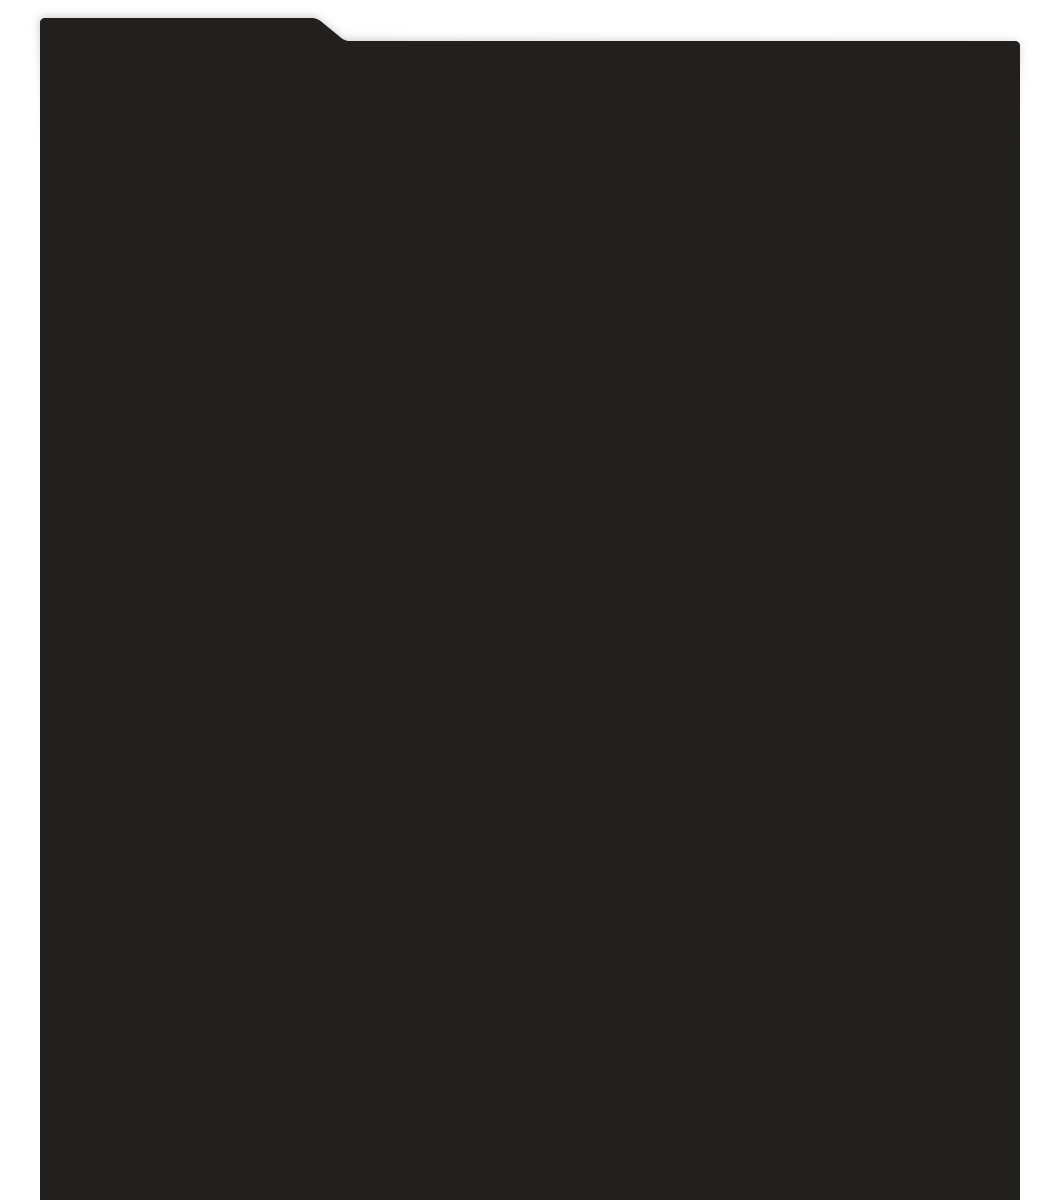
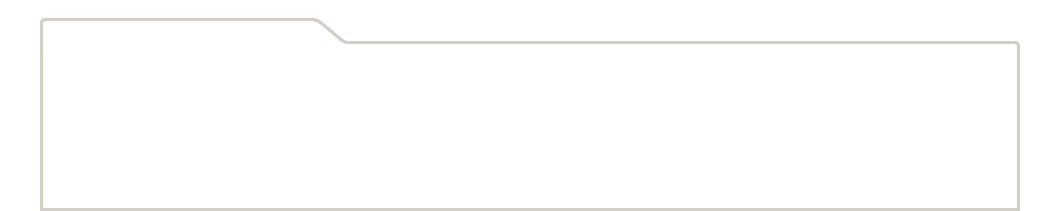
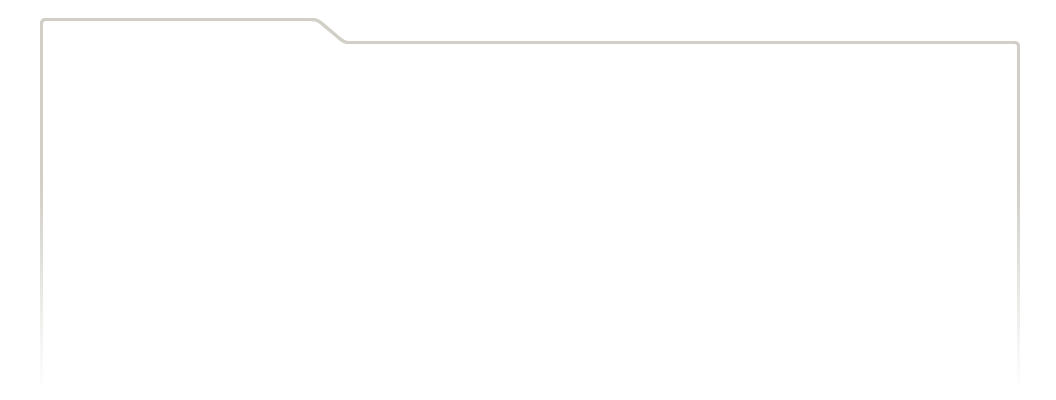
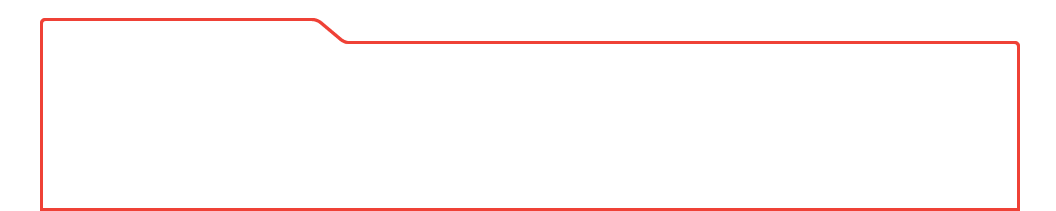
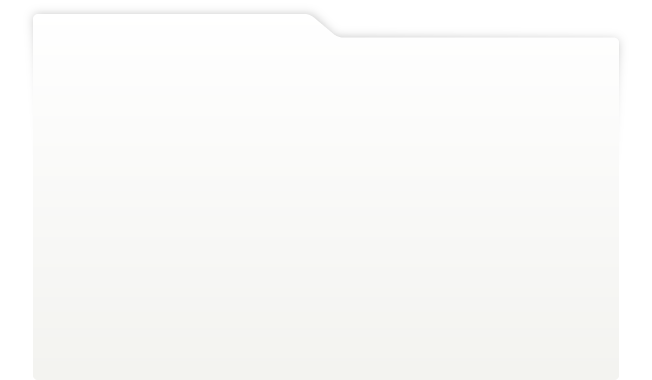
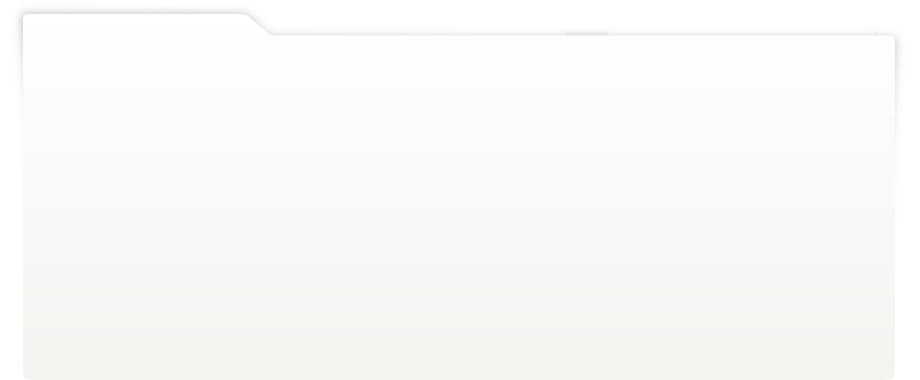
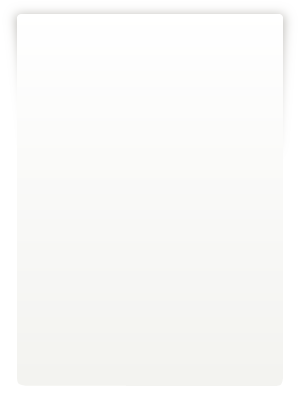
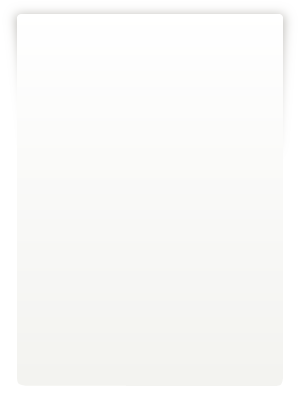
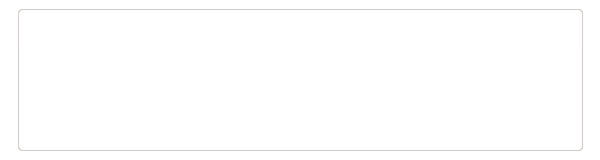
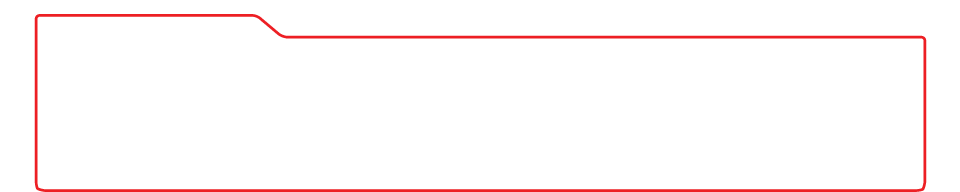
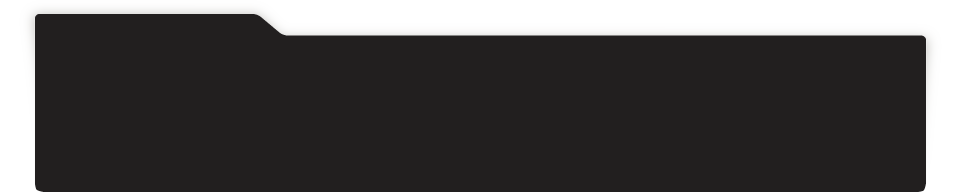
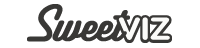
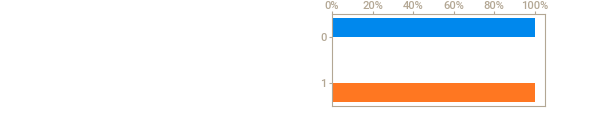
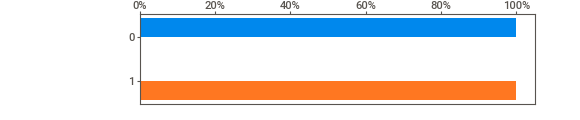
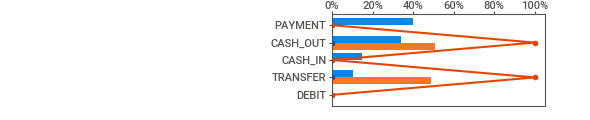
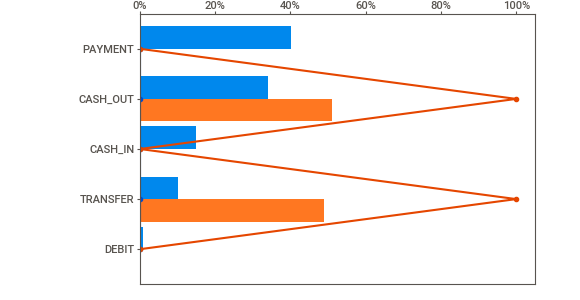
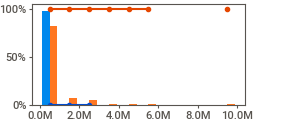
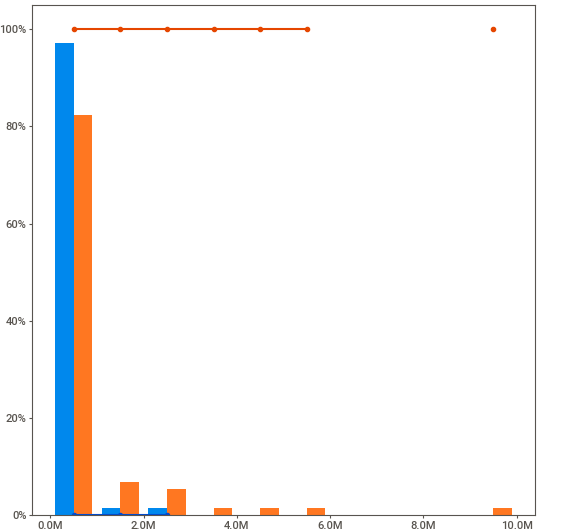
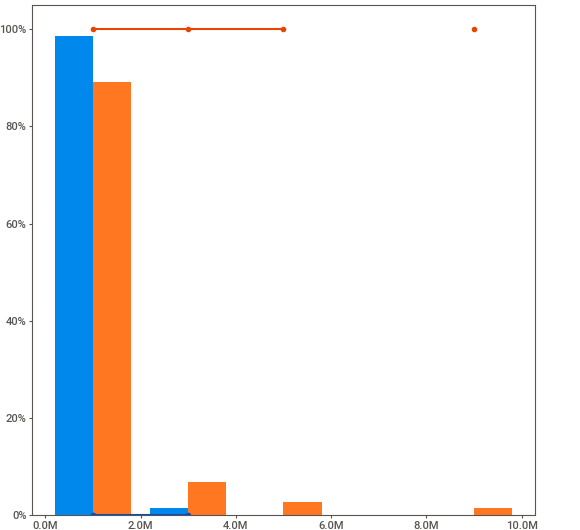
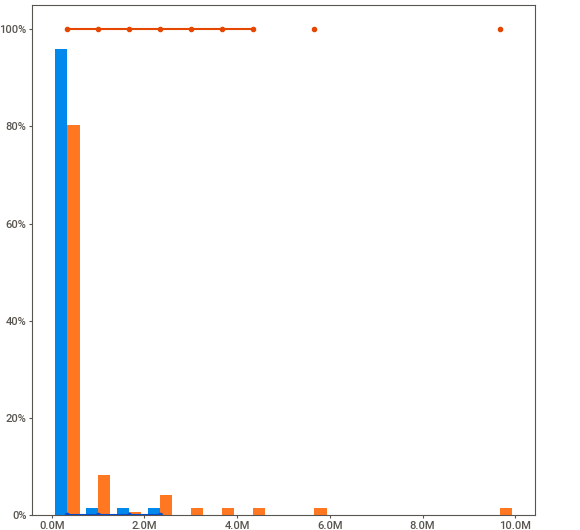
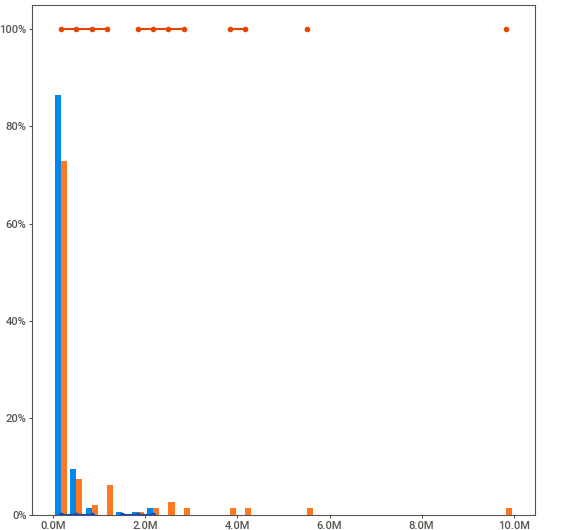
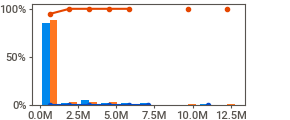
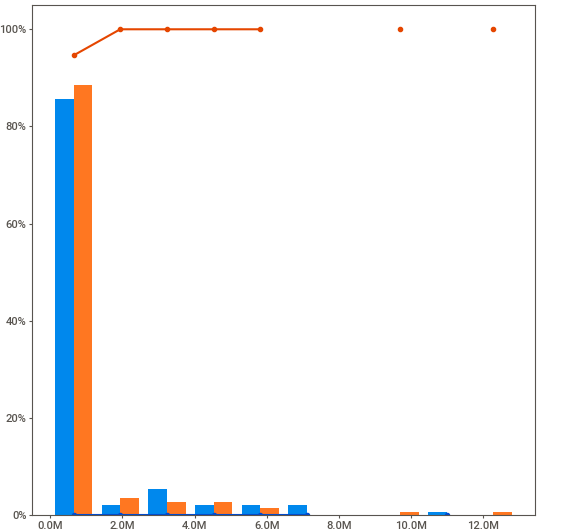
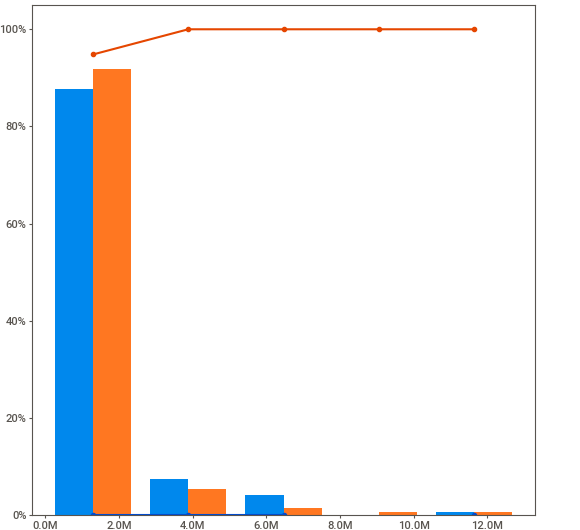
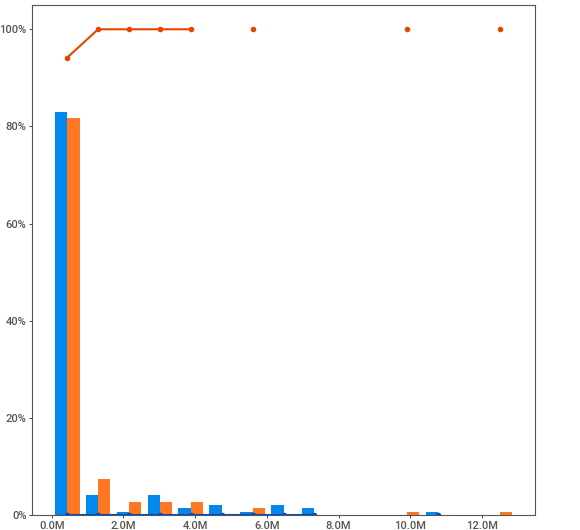
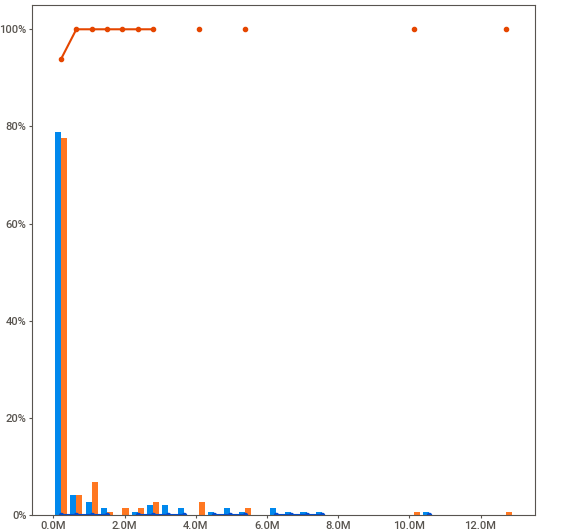
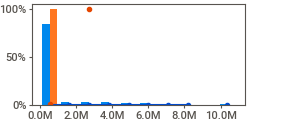
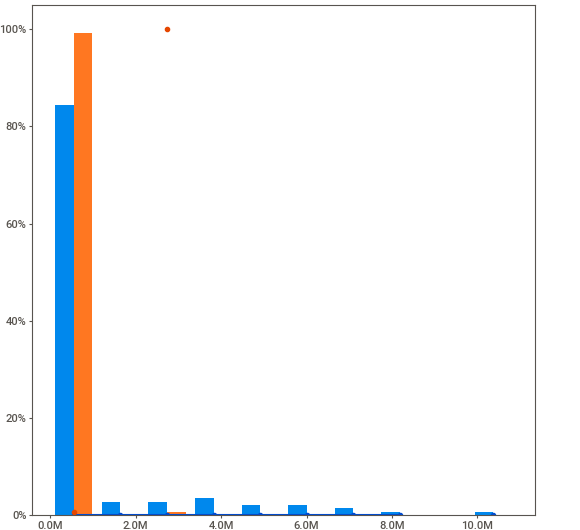
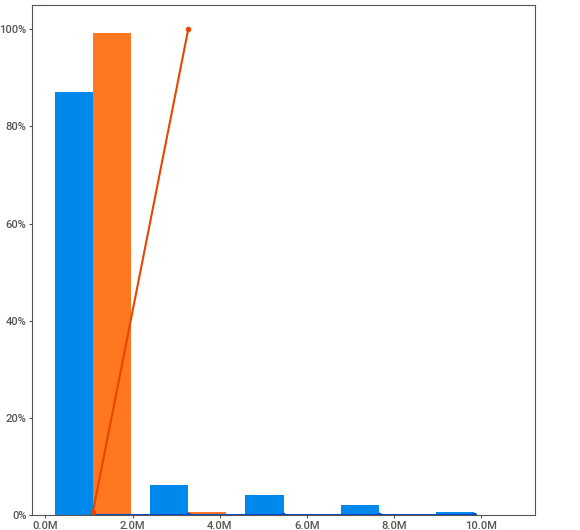
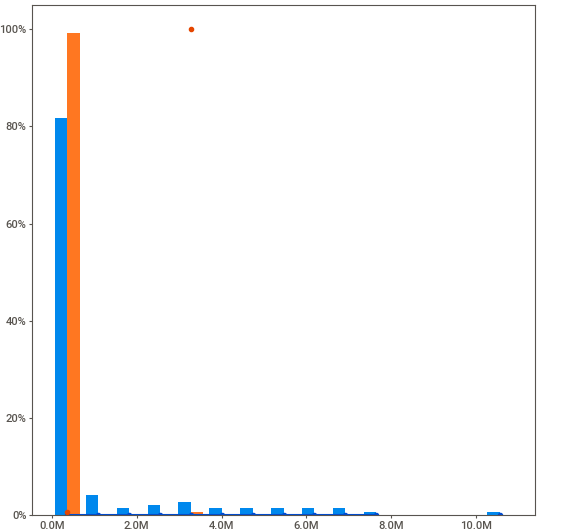
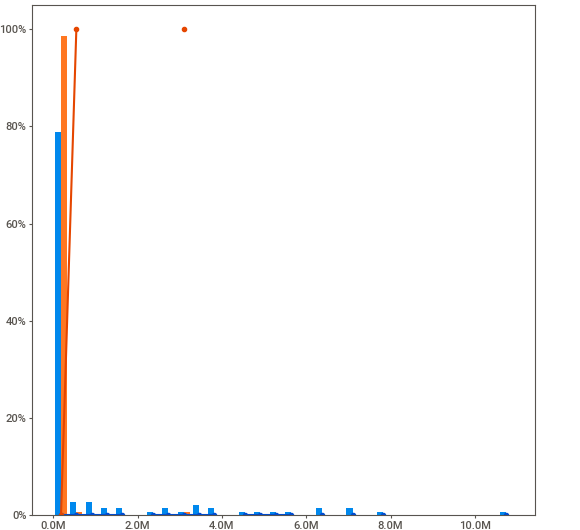
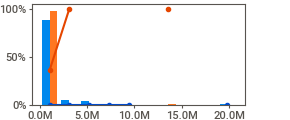
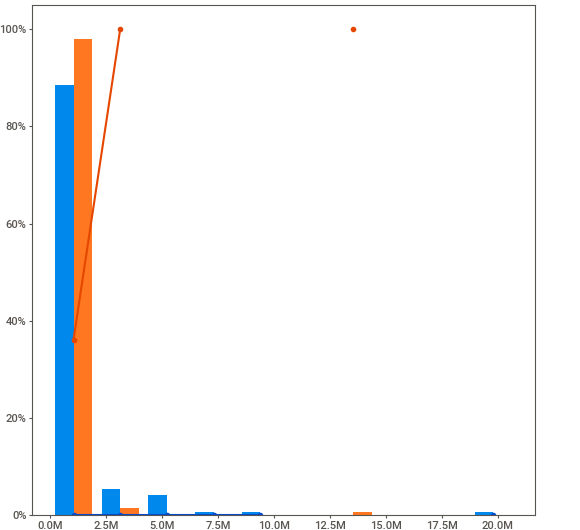
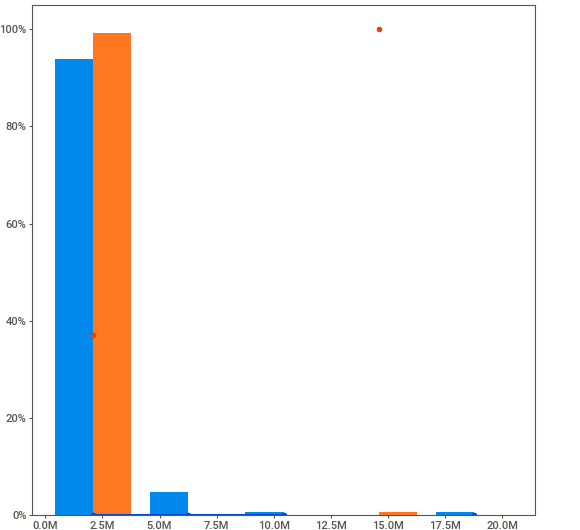
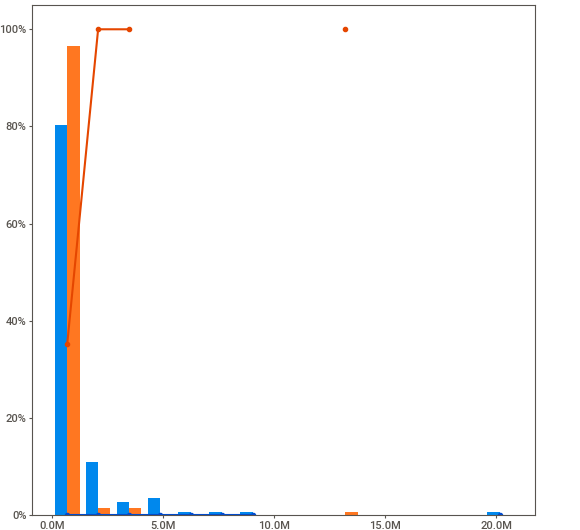
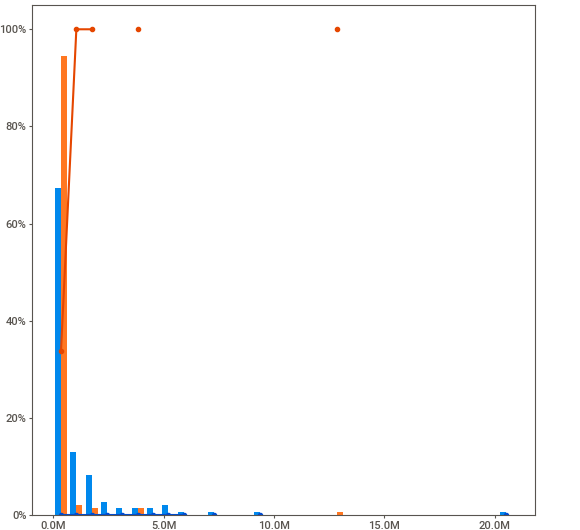
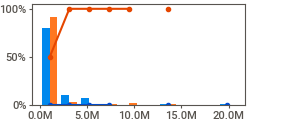
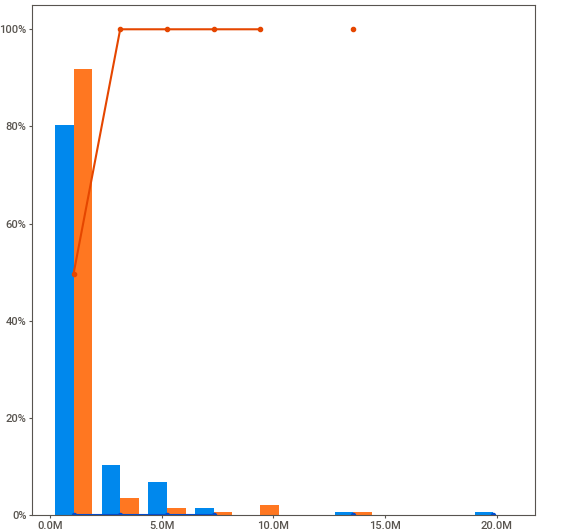
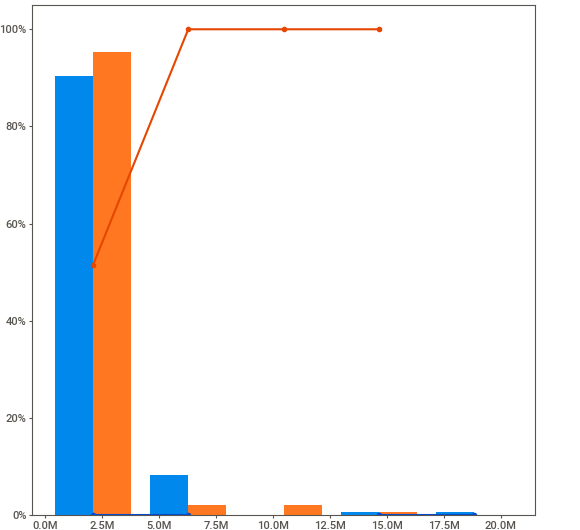
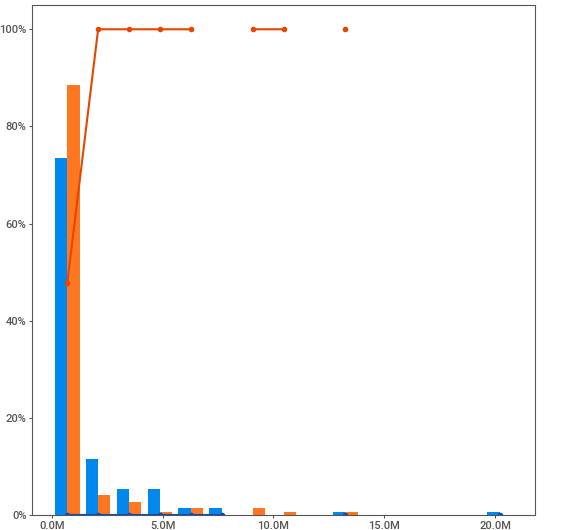
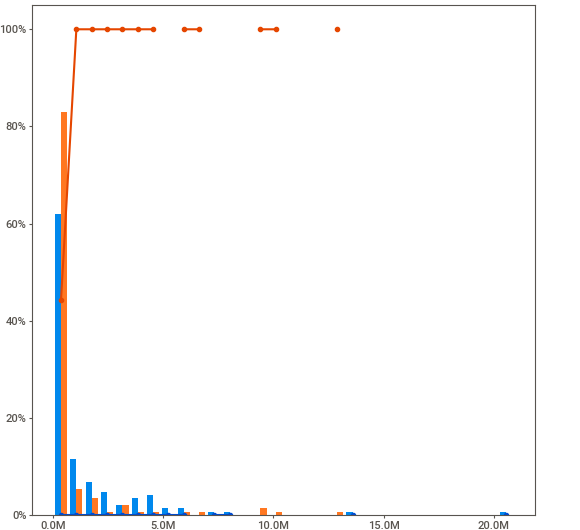
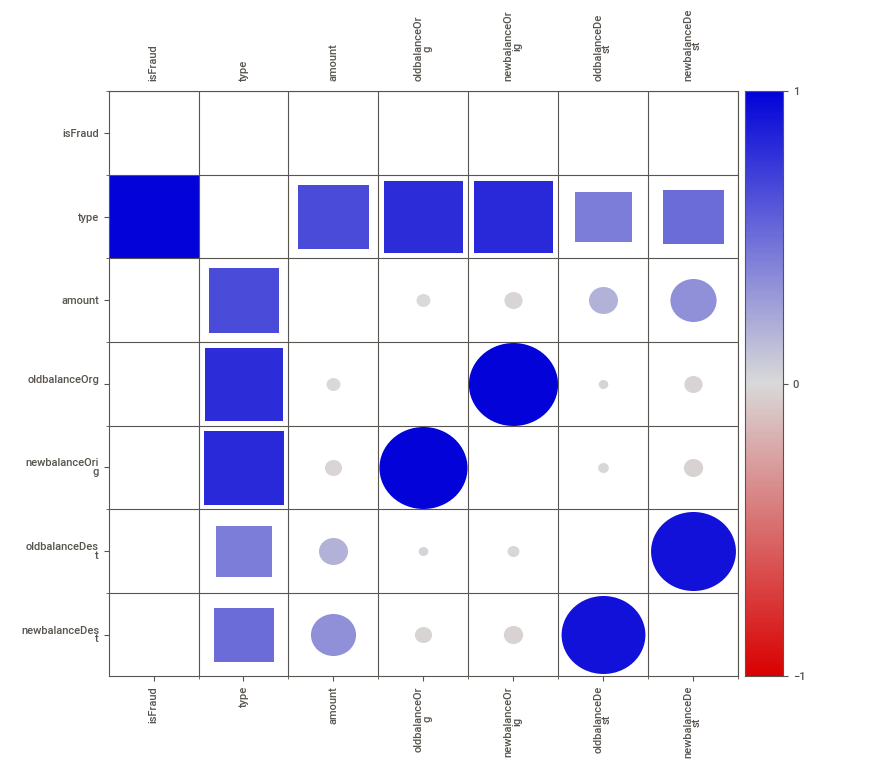
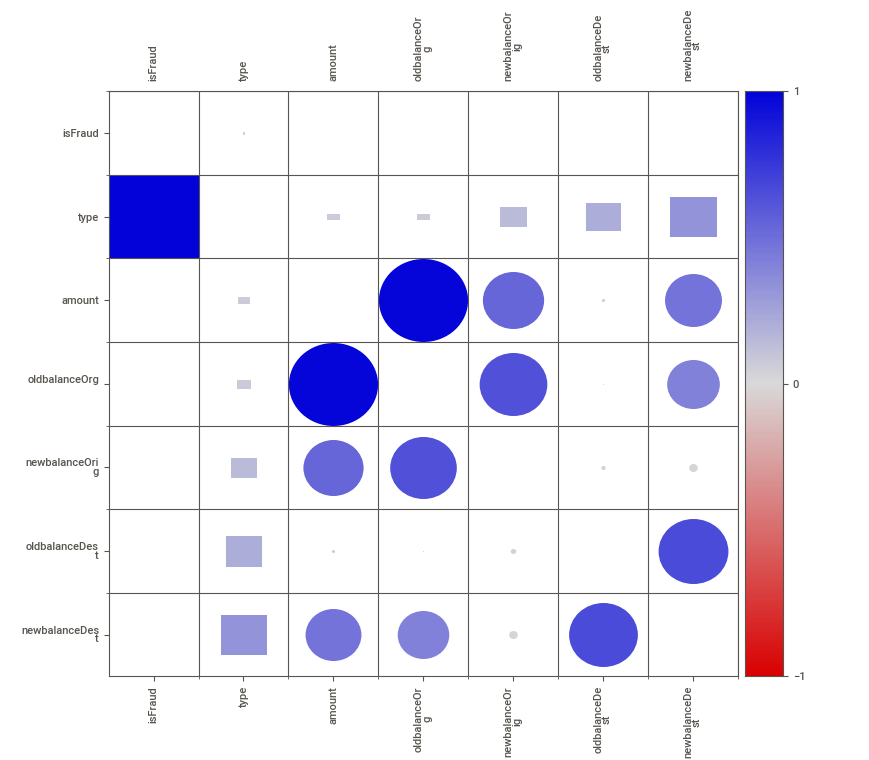

In [38]:
import sweetviz as sv

feature_config = sv.FeatureConfig(skip="step")
suspicious = balanced_df[balanced_df["isFraud"]==True]
not_suspicious = balanced_df[balanced_df["isFraud"]==False]
sweetviz_report = sv.compare((not_suspicious, "Normal"), (suspicious, "isFraud"), "isFraud", feature_config)
sweetviz_report.show_notebook()

## Feature Engineering
In predictive modeliing the appropriate choice of features  can dramatically affect the performance of a model. Feature engineering is one of the most crucial but yet underrated skills in machine learning.

Feature engineering is the process of transforming the raw data in a dataset to meaningful features that can be used in predictive modelling. This includes selecting/dropping existing data fields.It is also possible to enrich our dataset by deriving new features using existing fields. 

### Client Type

For instance the client name in our dataset could start with "C" and "F". Each prefix refers to a different type of client. However a statistical machine learning model with client name as input cannot identify this. Thus, it is beneficial to create a new field called "clientType" that encodes this information separately.

In [39]:
balanced_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,13,CASH_OUT,63540.34,C450440086,0.0,0.00,C1109113606,1622895.72,1352603.98,0
1,10,CASH_OUT,186222.62,C549731711,0.0,0.00,C395252462,1008416.08,1194638.70,0
2,13,PAYMENT,4440.61,C50312042,102782.0,98341.39,M453794668,0.00,0.00,0
3,13,CASH_IN,211279.16,C1467012896,3383082.0,3594361.16,C290687704,1899032.54,1089718.07,0
4,1,PAYMENT,9006.78,C1016633682,0.0,0.00,M2018220300,0.00,0.00,0


In [85]:
features = balanced_df.copy(deep=True)
features['sourceName'] = features['nameOrig'].str.contains('C')
features['destName'] = features['nameDest'].str.contains('C')
features.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,sourceName,destName
0,13,CASH_OUT,63540.34,C450440086,0.0,0.00,C1109113606,1622895.72,1352603.98,0,True,True
1,10,CASH_OUT,186222.62,C549731711,0.0,0.00,C395252462,1008416.08,1194638.70,0,True,True
2,13,PAYMENT,4440.61,C50312042,102782.0,98341.39,M453794668,0.00,0.00,0,True,False
3,13,CASH_IN,211279.16,C1467012896,3383082.0,3594361.16,C290687704,1899032.54,1089718.07,0,True,True
4,1,PAYMENT,9006.78,C1016633682,0.0,0.00,M2018220300,0.00,0.00,0,True,False


### Transaction Destination

Also notice the NaN fields in clientB, profileB and locationB fields of our dataset. Sometimes null fields can be caused by failure in data gathering processes however, other times, null fields can encode rich information.

In this case, we can use these fields to annotate which of those transactions do not have a destination.

In [86]:
features['hasDest'] = ~features['nameDest'].isnull()

## Hour of the day
In addition, the timestamps of each record in our dataset are currently unique which render them useless for our model. However there is a lot of information encoded there that can be used such as the hour of the day. It is reasonable to think that there could be a correlation between the hour in the day that the transaction took place and the "suspicious" field.

In [ ]:
# features["hourInDay"] = pd.to_datetime(features["date"], infer_datetime_format=True).dt.hour 
# features["dayOfWeek"] = pd.to_datetime(features["date"], infer_datetime_format=True).dt.day

## Drop fields
Let's also drop the extraneous fields from the dataset.

In [87]:
features = features.drop(columns=['nameOrig', 'nameDest', 'step'])

In [88]:
features = features.fillna(-1)
features["sourceName"] = features["sourceName"].astype(int)
features["destName"] = features["destName"].astype(int)
features["destName"] = features["hasDest"].astype(int)

In [89]:
features

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,sourceName,destName,hasDest
0,CASH_OUT,63540.34,0.00,0.00,1622895.72,1352603.98,0,1,1,True
1,CASH_OUT,186222.62,0.00,0.00,1008416.08,1194638.70,0,1,1,True
2,PAYMENT,4440.61,102782.00,98341.39,0.00,0.00,0,1,1,True
3,CASH_IN,211279.16,3383082.00,3594361.16,1899032.54,1089718.07,0,1,1,True
4,PAYMENT,9006.78,0.00,0.00,0.00,0.00,0,1,1,True
...,...,...,...,...,...,...,...,...,...,...
289,CASH_OUT,408.00,408.00,0.00,898297.85,1075854.14,1,1,1,True
290,TRANSFER,48375.02,48375.02,0.00,0.00,0.00,1,1,1,True
291,CASH_OUT,48375.02,48375.02,0.00,374803.26,658520.33,1,1,1,True
292,TRANSFER,4022667.54,4022667.54,0.00,0.00,0.00,1,1,1,True


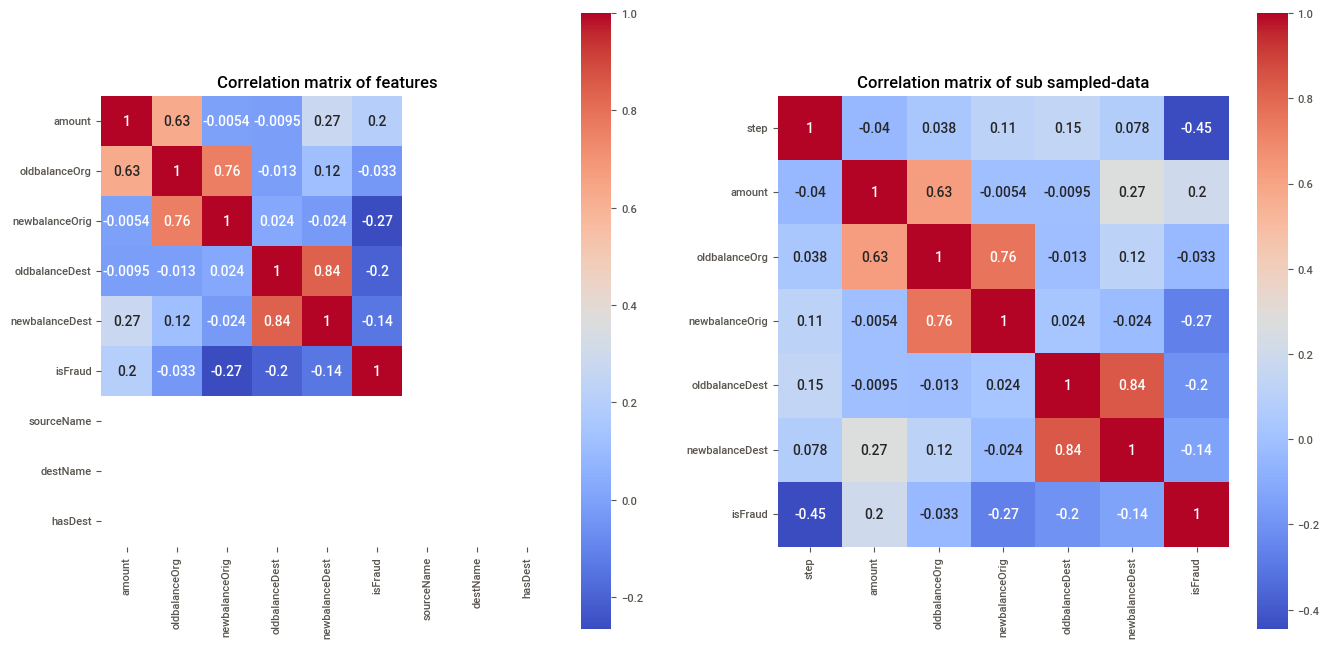

In [90]:
# features = features[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
#                      'newbalanceDest', 'isFraud', 'sourceName', 'destName', 'hasDest']]

features_corrmat = features.corr()
f, ax = plt.subplots(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Correlation matrix of features')

sns.heatmap(features_corrmat, vmax=1, square=True, annot=True, cmap='coolwarm')
plt.subplot(1, 2, 2)
plt.title('Correlation matrix of sub sampled-data')
sns.heatmap(corrmat, vmax=1, square=True, annot=True, cmap='coolwarm');

In [108]:
X = features.drop(['isFraud'], axis=1)
y = pd.DataFrame(features['isFraud'], columns=['isFraud'])
y

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
289,1
290,1
291,1
292,1


## Categorical variables

In [109]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,sourceName,destName,hasDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,63540.34,0.0,0.00,1622895.72,1352603.98,1,1,True,1,0,0,0
1,186222.62,0.0,0.00,1008416.08,1194638.70,1,1,True,1,0,0,0
2,4440.61,102782.0,98341.39,0.00,0.00,1,1,True,0,0,1,0
3,211279.16,3383082.0,3594361.16,1899032.54,1089718.07,1,1,True,0,0,0,0
4,9006.78,0.0,0.00,0.00,0.00,1,1,True,0,0,1,0


# Modeling

We will first split the data into training and test sets, with a 80/20 split. This is done to measure and avoid possible overfitting. By measuring the model's performance on separate data, we have a more fair assessment of the model's ability to extrapolate its predictions to new or unseen information.



In [65]:
from sklearn.model_selection import train_test_split 

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(205, 12)
(205, 1)
(89, 12)
(89, 1)


## Decision Tree

At a high level, a decision tree model works by sequentially splitting the dataset along value thresholds of the predictor variables. The splits are determined by a criteria that quantifies how different two sets of data are (by default, Gini impurity). For example, if fraudulent transactions most frequently occur with amounts over 1,000,000, while non-fraudulent transactions are more frequently of lower amounts, our decision tree is likely to use amount as a node that splits our dataset into transactions of those over 1,000,000 and those that are less. The decision tree then considers each of those two groups and attempts to perform another split on one of the other features, and so on, until the split groups have zero impurity (all the members of each group have the same classification). While in actuality the data does not contain such explicit separations, this is the general logic used by the algorithm. In a basic sense, it can be thought of as categorizing the data based on its features. It repeats the process iteratively on each branch until an end (leaf) is reached, hence the "tree".


An advantage of using decision trees is that the results are highly interpretable and easy to visualize. This means we will be able to see exactly how the decision tree constructs itself, and what features it prioritizes in its construction. It will show us how the data is being split and by what values for each feature will lead to a certain classification. The same cannot be said for certain "black box" methods of modeling, such as neural networks—which despite their potential for high performance, are often too complex to be intuitively understood and explained, even by the model developer.


Let's implement the decision tree and measure its performance.

In [111]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=1)

dt_clf = dt_clf.fit(X_train,y_train)

y_pred = dt_clf.predict(X_test)

In [112]:
result = pd.DataFrame({'actual':y_test['isFraud'], 'predicted':y_pred})
result[result['actual']==1]

,actual,predicted
268,1,1
269,1,0
280,1,1
167,1,1
147,1,1
273,1,1
182,1,1
191,1,1
232,1,1
225,1,1


# Quantifying Performance

![](https://miro.medium.com/max/700/0*JpiWBlOFqYTPa8Ta.png)

Let's look at some metrics commonly used for measuring model performance. The sklearn.metrics.classification_report function gives us a nice printout for assessing performance, including precision, recall, and f1-score for each of the classes independently. The separation for the classes is important especially when dealing with imbalanced data, as we are now. All of these metrics range from 0 to 1, higher numbers representing better accuracy.

- **Precision:**  Precision is penalized by having more false positives. i.e what proportion of predicted Positives is truly Positive?

![](https://miro.medium.com/max/444/1*C3ctNdO0mde9fa1PFsCVqA.png)
![](https://miro.medium.com/max/700/1*PULzWEven_XAZjiMNizDCg.png)


- **Recall:**  Recall is penalized by having more false negatives. what proportion of actual Positives is correctly classified?

![](https://miro.medium.com/max/418/1*dXkDleGhA-jjZmZ1BlYKXg.png)
![](https://miro.medium.com/max/700/1*BBhWQC-m0CLN4sVJ0h5fJQ.jpeg)

- **F1 score:** The harmonic mean of precision and recall.

![](https://miro.medium.com/max/282/1*T6kVUKxG_Z4V5Fm1UXhEIw.png)

Another measure we can use is Area Under Curve (AUC), which refers to the area under the ROC curve, which is a plot of the true positive rate against the false positive rate. AUC also ranges from 0 to 1 and is frequently used as a quick way to compare model performance.

In [116]:
from sklearn.metrics import *

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        41
           1       0.90      0.96      0.93        48

    accuracy                           0.92        89
   macro avg       0.92      0.92      0.92        89
weighted avg       0.92      0.92      0.92        89



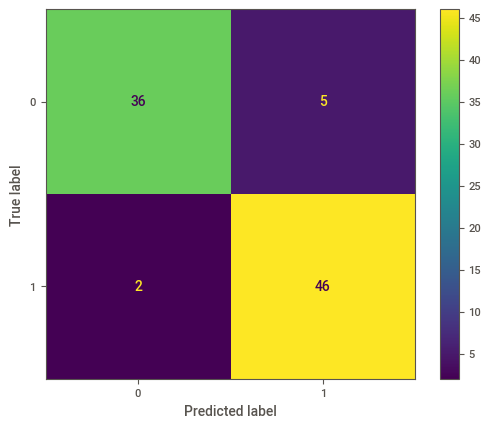

In [122]:
# metrics.plot_confusion_matrix(dt_clf, X_test, y_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

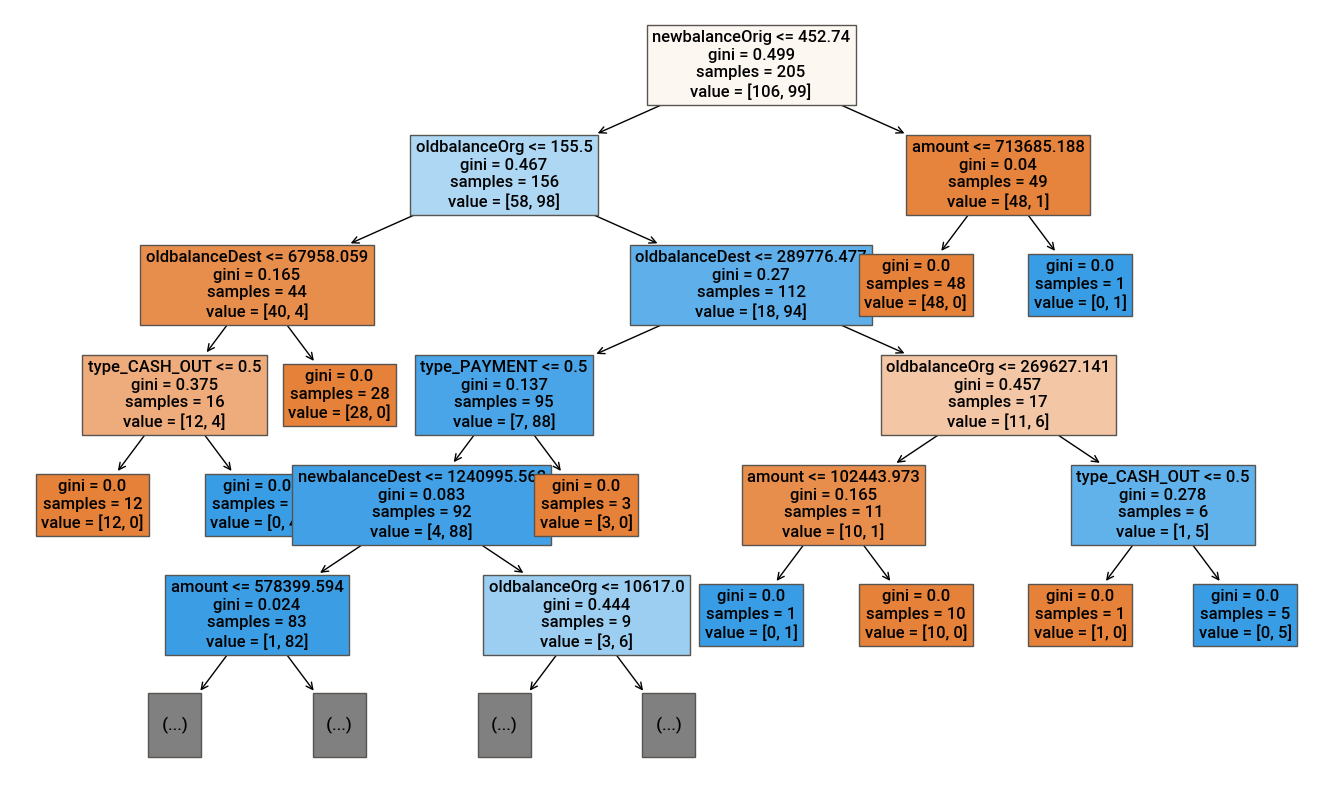

In [123]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(17,10))
_ = plot_tree(dt_clf, max_depth=5, feature_names=list(X_train.columns), filled=True, fontsize=12)

## Feature Importance
In order to objectively determine each features' influence on the predictions, we can calculate, summed up for each feature, the amount by which it reduces impurity in each node it represents. Sklearn provides these values in the feature_importances_ attribute of DecisionTreeClassifier.



In [124]:
fi = pd.DataFrame({'features':X_train.columns,'importance':dt_clf.feature_importances_}).sort_values(by=['importance'], ascending=False)
fi

,features,importance
1,oldbalanceOrg,0.444401
2,newbalanceOrig,0.269089
3,oldbalanceDest,0.105038
8,type_CASH_OUT,0.074884
10,type_PAYMENT,0.051926
0,amount,0.038288
4,newbalanceDest,0.016373
5,sourceName,0.000000
6,destName,0.000000
7,hasDest,0.000000


### Most import Features

- oldbalanceOrg: 44.44%
- newbalanceOrig: 26.90%
- oldbalanceDest: 10.90%

These account for about 82% of all features.

<Axes: xlabel='importance', ylabel='features'>

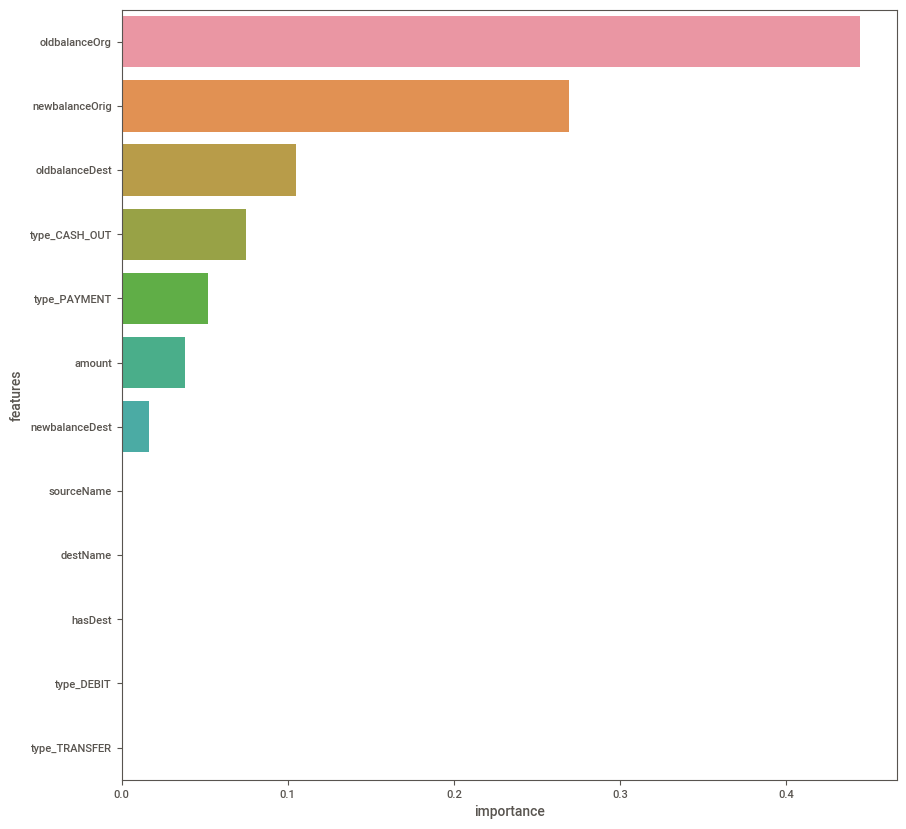

In [125]:
plt.figure(figsize=(10,10))

sns.barplot(x="importance", y="features", data=fi)